In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Размер матрицы: (1104, 736)
Тип данных: uint8
Диапазон значений: [16, 246]
Пример значений:
[[66 58 74 83 66]
 [81 76 81 85 77]
 [77 77 71 70 76]
 [65 72 60 59 77]
 [69 78 68 67 86]]


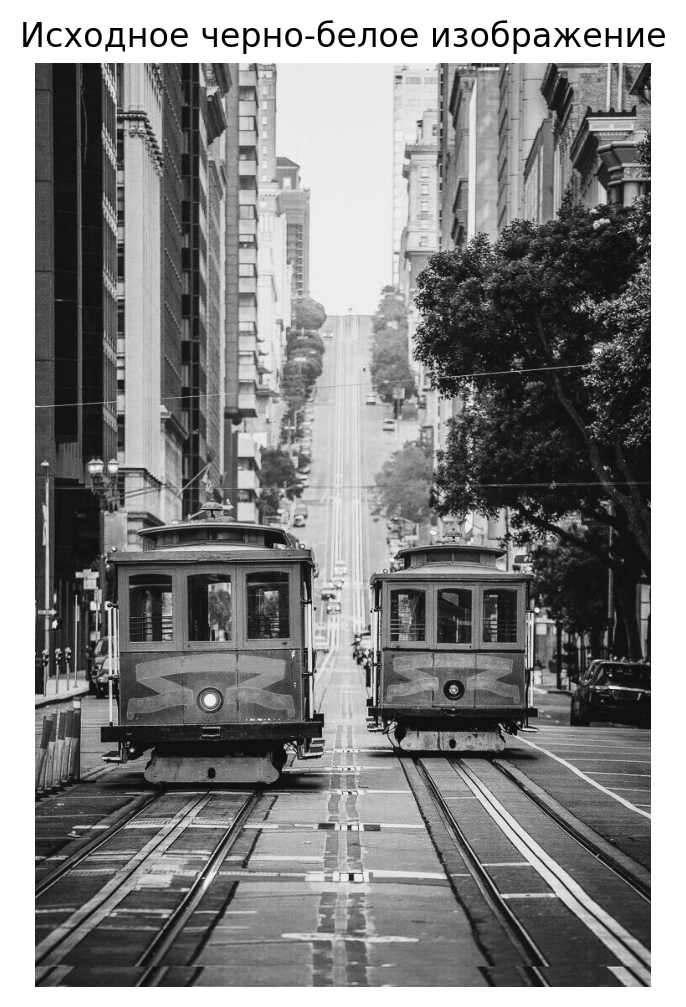

In [12]:
# Загрузка и анализ изображения
image = Image.open('street.jpg').convert('L')
image_array = np.array(image)

print(f"Размер матрицы: {image_array.shape}")
print(f"Тип данных: {image_array.dtype}")
print(f"Диапазон значений: [{image_array.min()}, {image_array.max()}]")
print(f"Пример значений:\n{image_array[:5, :5]}")

# Показываем исходное изображение
plt.figure(figsize=(8, 6))
plt.imshow(image_array, cmap='gray')
plt.title('Исходное черно-белое изображение')
plt.axis('off')
plt.show()

Всего сингулярных чисел: 736


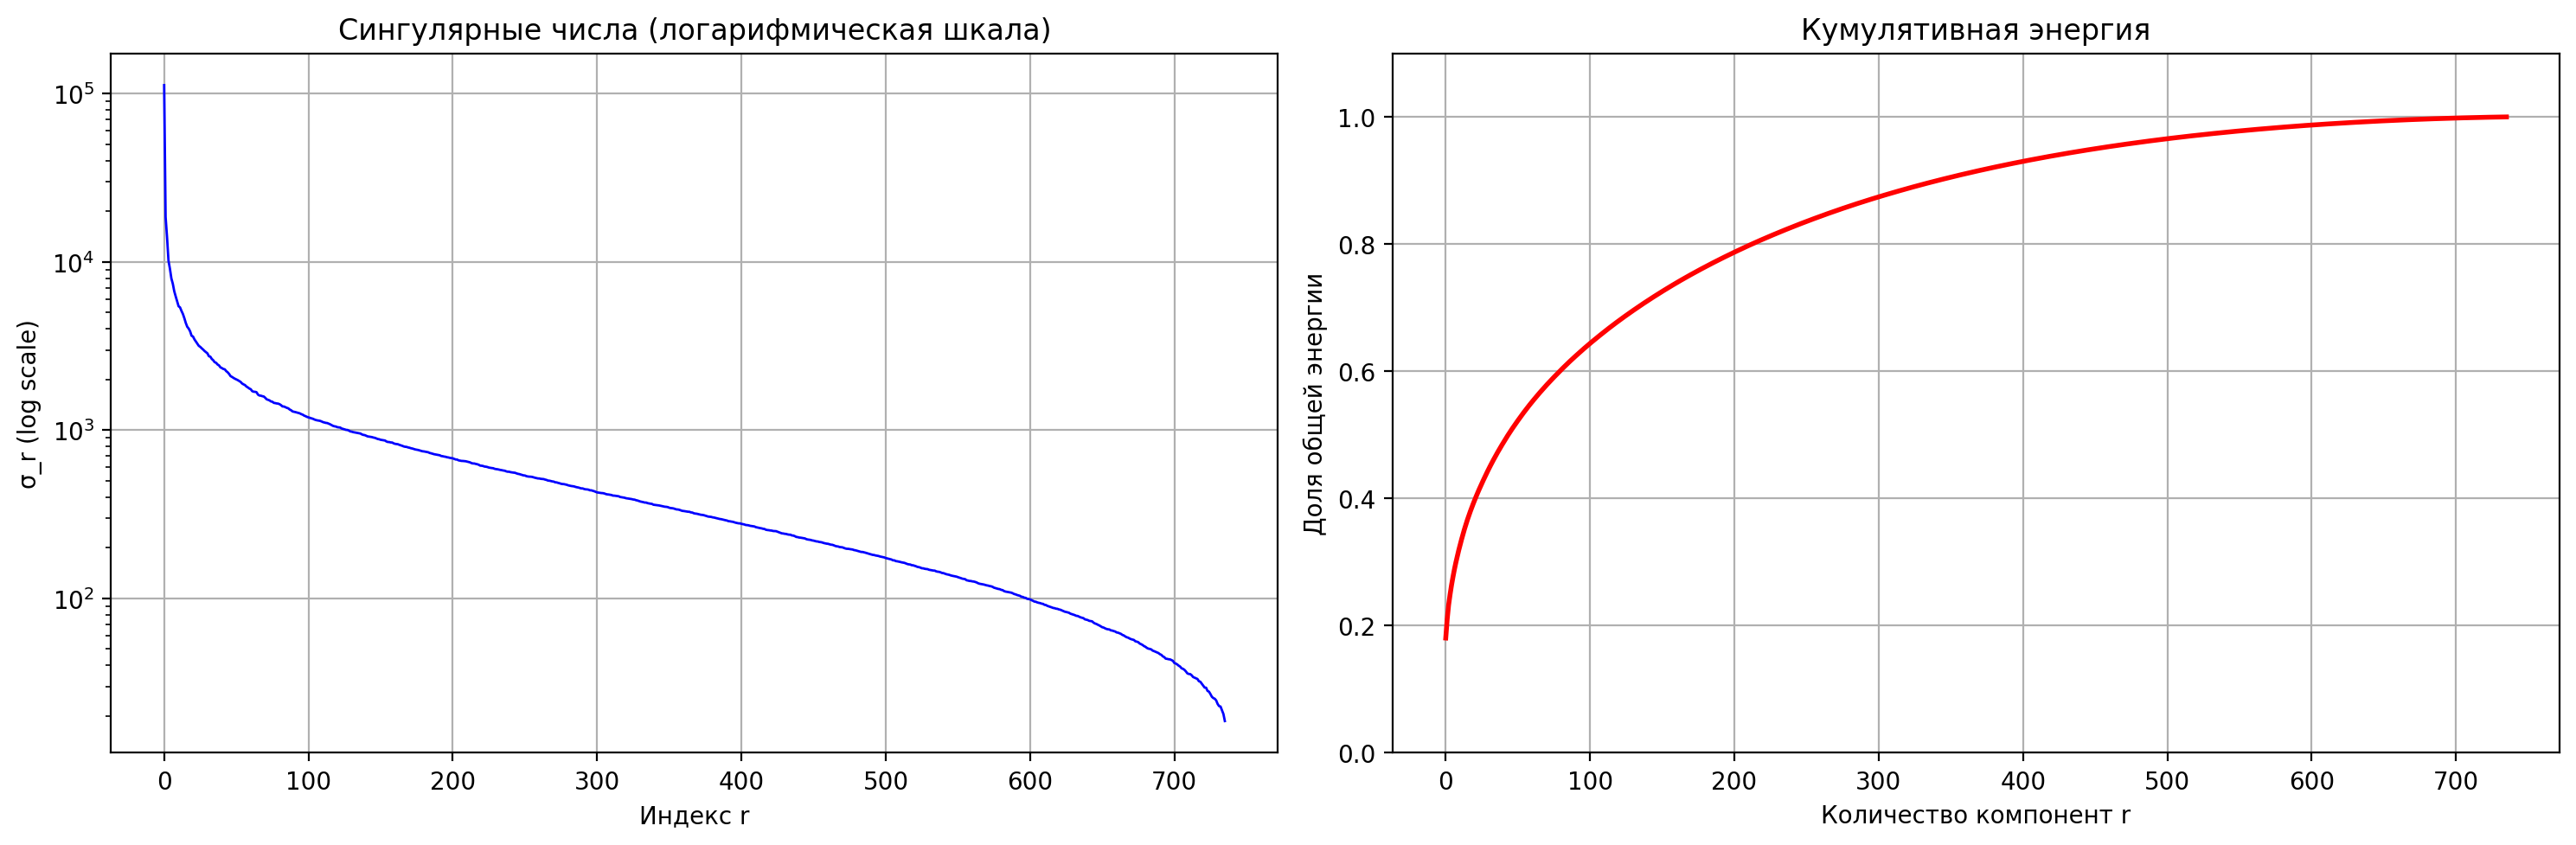

In [19]:
# Сингулярное разложение и анализ
# Выполняем SVD
U, S, VT = np.linalg.svd(image_array, full_matrices=False)

total_singular_values = len(S)
print(f"Всего сингулярных чисел: {total_singular_values}")

# кумулятивная энергия
cumulative_energy = np.cumsum(S) / np.sum(S)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.semilogy(S, 'b-', linewidth=1)
ax1.set_title('Сингулярные числа (логарифмическая шкала)')
ax1.set_xlabel('Индекс r')
ax1.set_ylabel('σ_r (log scale)')
ax1.grid(True)

ax2.plot(cumulative_energy, 'r-', linewidth=2)
ax2.set_title('Кумулятивная энергия')
ax2.set_xlabel('Количество компонент r')
ax2.set_ylabel('Доля общей энергии')
ax2.grid(True)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ SVD
Уровень    r        % энергии    Ошибка Фробениуса   
--------------------------------------------------
10%        73       58.36     % 151589.40           
5%         36       46.87     % 151133.05           
1%         7        28.84     % 150026.12           
0.2%       1        18.05     % 146640.38           


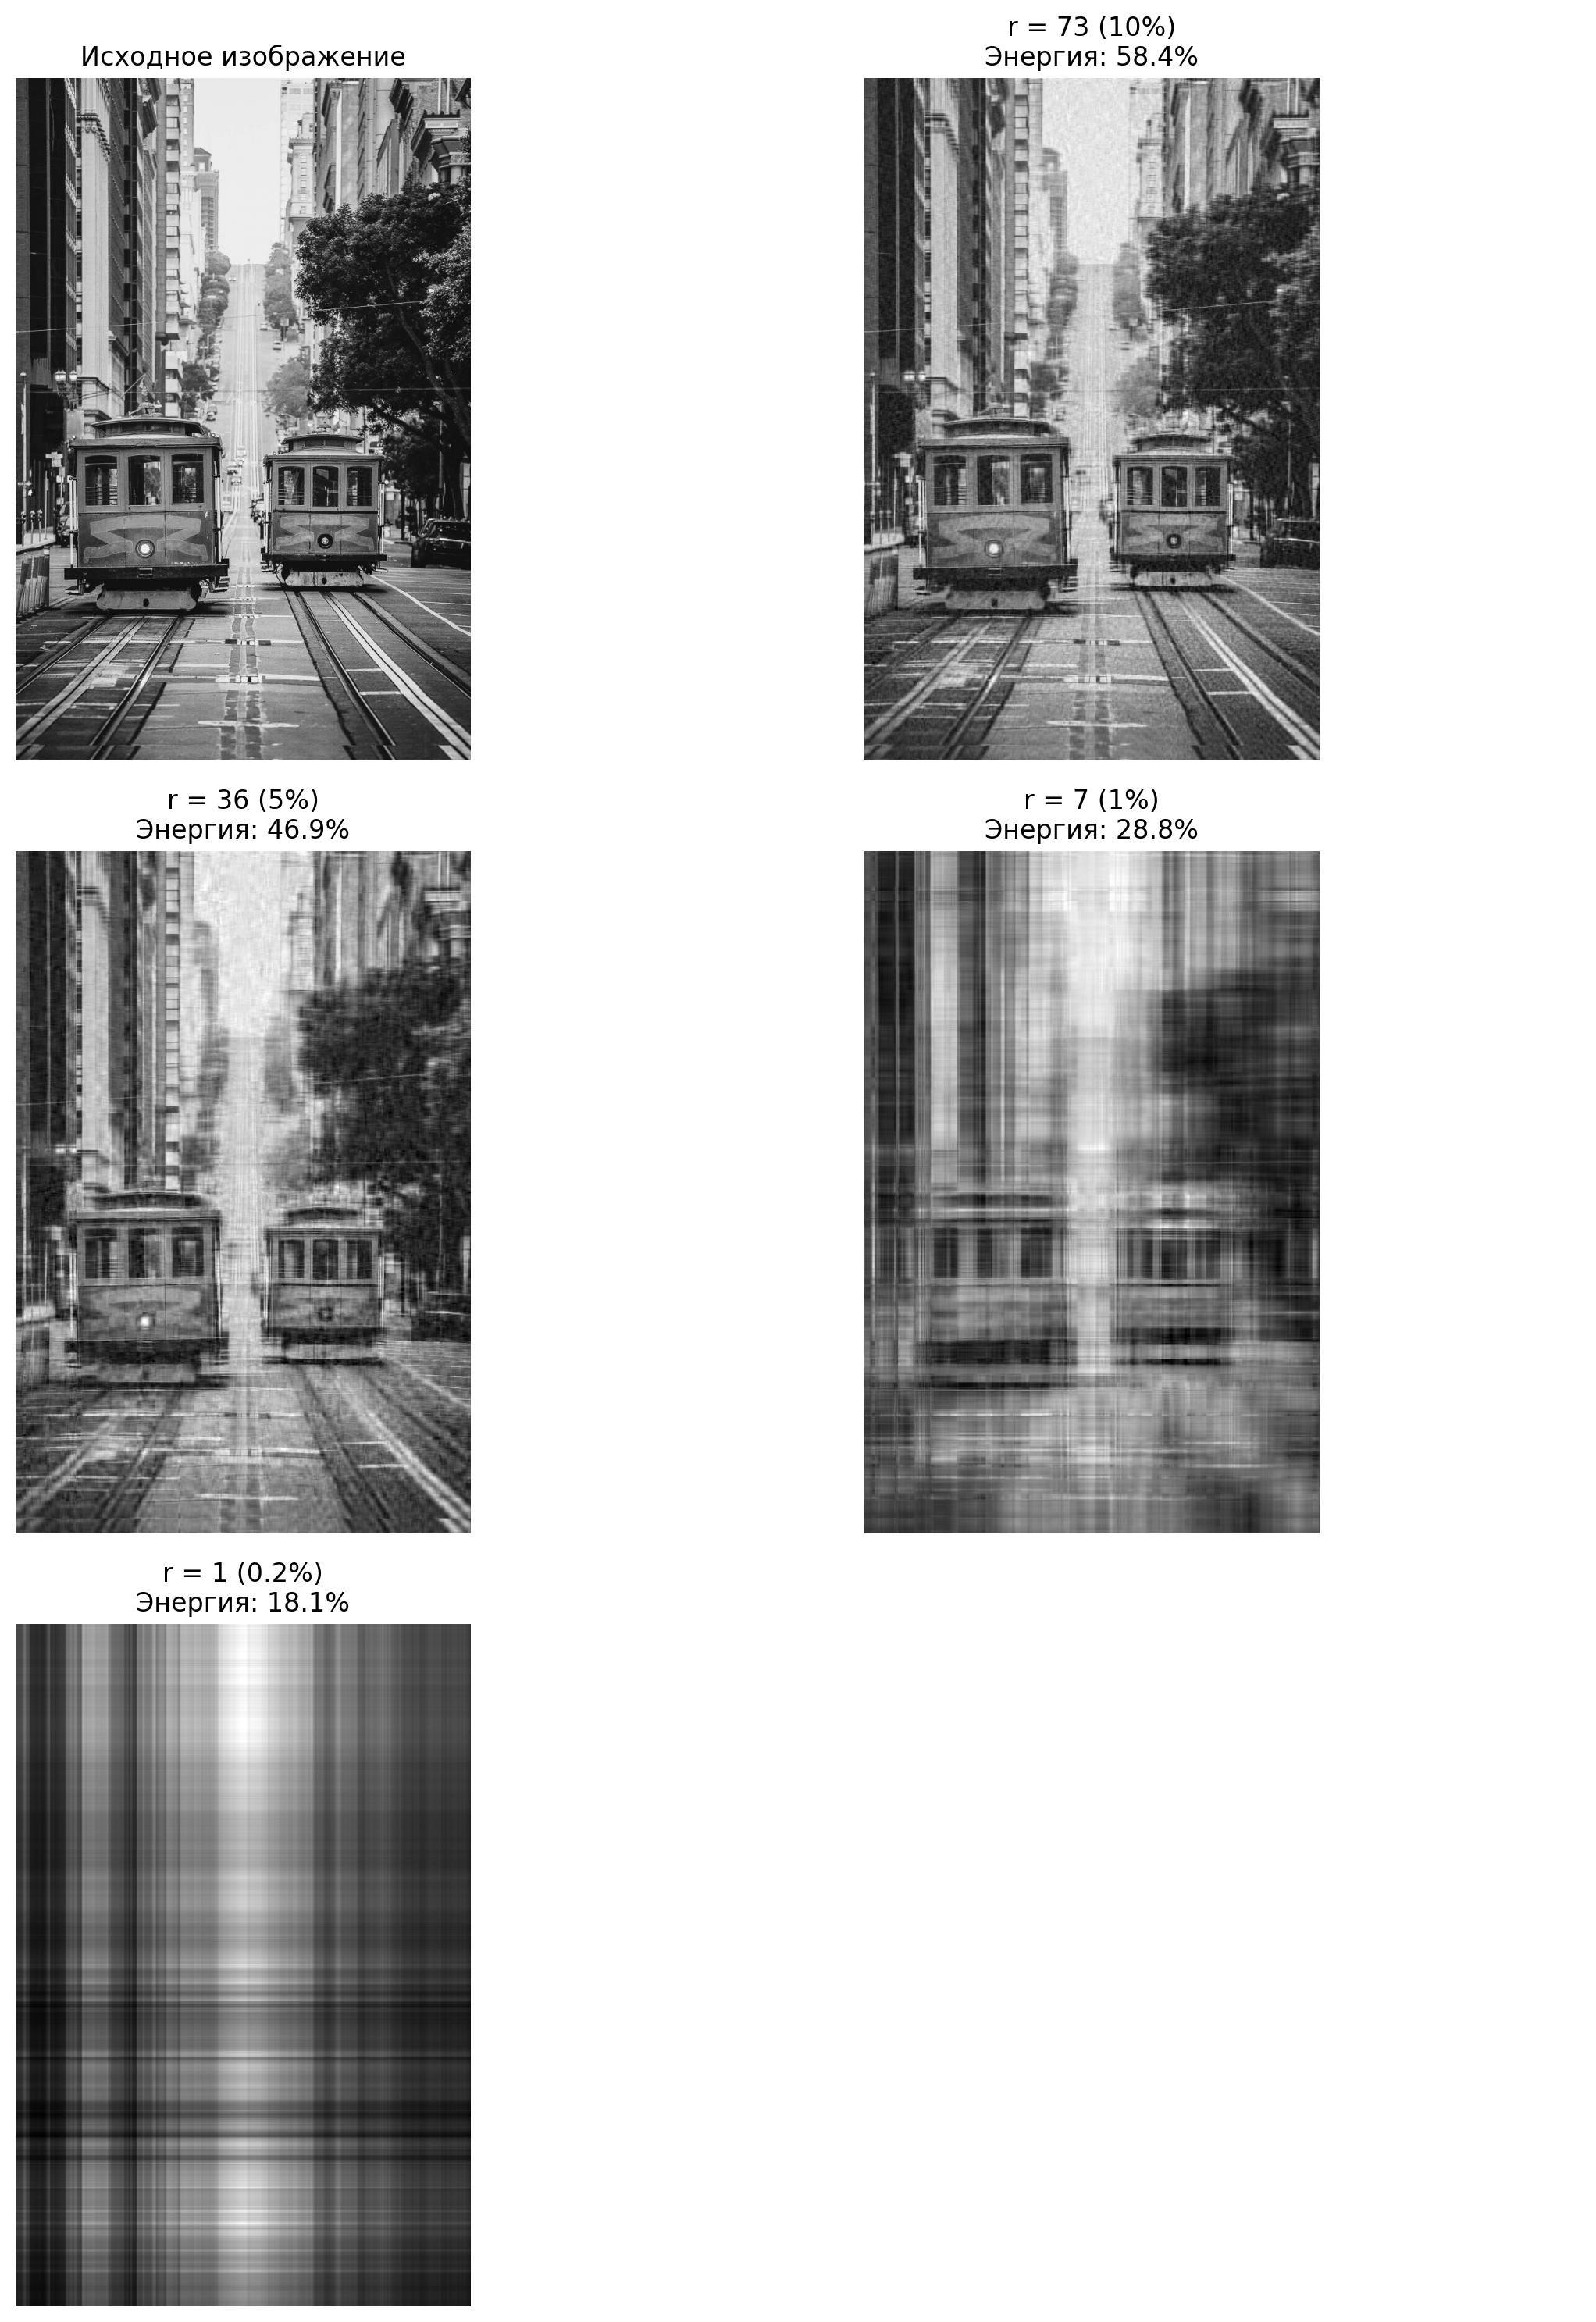

In [20]:
# Визуализация сжатия с разными уровнями
compression_ratios = [0.10, 0.05, 0.01, 0.002]
ratios_names = ['10%', '5%', '1%', '0.2%']

print("РЕЗУЛЬТАТЫ СЖАТИЯ С ПОМОЩЬЮ SVD")
print("=" * 50)
print(f"{'Уровень':<10} {'r':<8} {'% энергии':<12} {'Ошибка Фробениуса':<20}")
print("-" * 50)

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.ravel()

axes[0].imshow(image_array, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

# Восстановленные изображения
for i, (ratio, name) in enumerate(zip(compression_ratios, ratios_names)):
    r = max(1, int(total_singular_values * ratio))
    #SVD-восстановление с усечением
    reconstructed = U[:, :r] @ np.diag(S[:r]) @ VT[:r, :]
    reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)
    
    energy_percentage = cumulative_energy[r-1] * 100
    error_norm = np.linalg.norm(image_array - reconstructed, 'fro')
    
    print(f"{name:<10} {r:<8} {energy_percentage:<10.2f}% {error_norm:<20.2f}")
    
    axes[i+1].imshow(reconstructed, cmap='gray')
    axes[i+1].set_title(f'r = {r} ({name})\nЭнергия: {energy_percentage:.1f}%')
    axes[i+1].axis('off')

if len(axes) > len(compression_ratios) + 1:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Анализ эффективности сжатия
print("\nДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ")
print("=" * 40)
print(f"Размер исходной матрицы: {image_array.shape}")
print(f"Общее количество элементов: {image_array.size}")

# Экономия памяти
print("\nЭКОНОМИЯ ПАМЯТИ:")
print(f"{'Уровень':<10} {'r':<8} {'Исходный размер':<18} {'Сжатый размер':<16} {'Коэф. сжатия':<12}")
print("-" * 65)

m, n = image_array.shape
for ratio, name in zip(compression_ratios, ratios_names):
    r = max(1, int(total_singular_values * ratio))
    
    original_size = m * n
    compressed_size = m * r + r + r * n
    compression_ratio = original_size / compressed_size
    
    print(f"{name:<10} {r:<8} {original_size:<18} {compressed_size:<16} {compression_ratio:<10.2f}x")


ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ
Размер исходной матрицы: (1104, 736)
Общее количество элементов: 812544

ЭКОНОМИЯ ПАМЯТИ:
Уровень    r        Исходный размер    Сжатый размер    Коэф. сжатия
-----------------------------------------------------------------
10%        73       812544             134393           6.05      x
5%         36       812544             66276            12.26     x
1%         7        812544             12887            63.05     x
0.2%       1        812544             1841             441.36    x


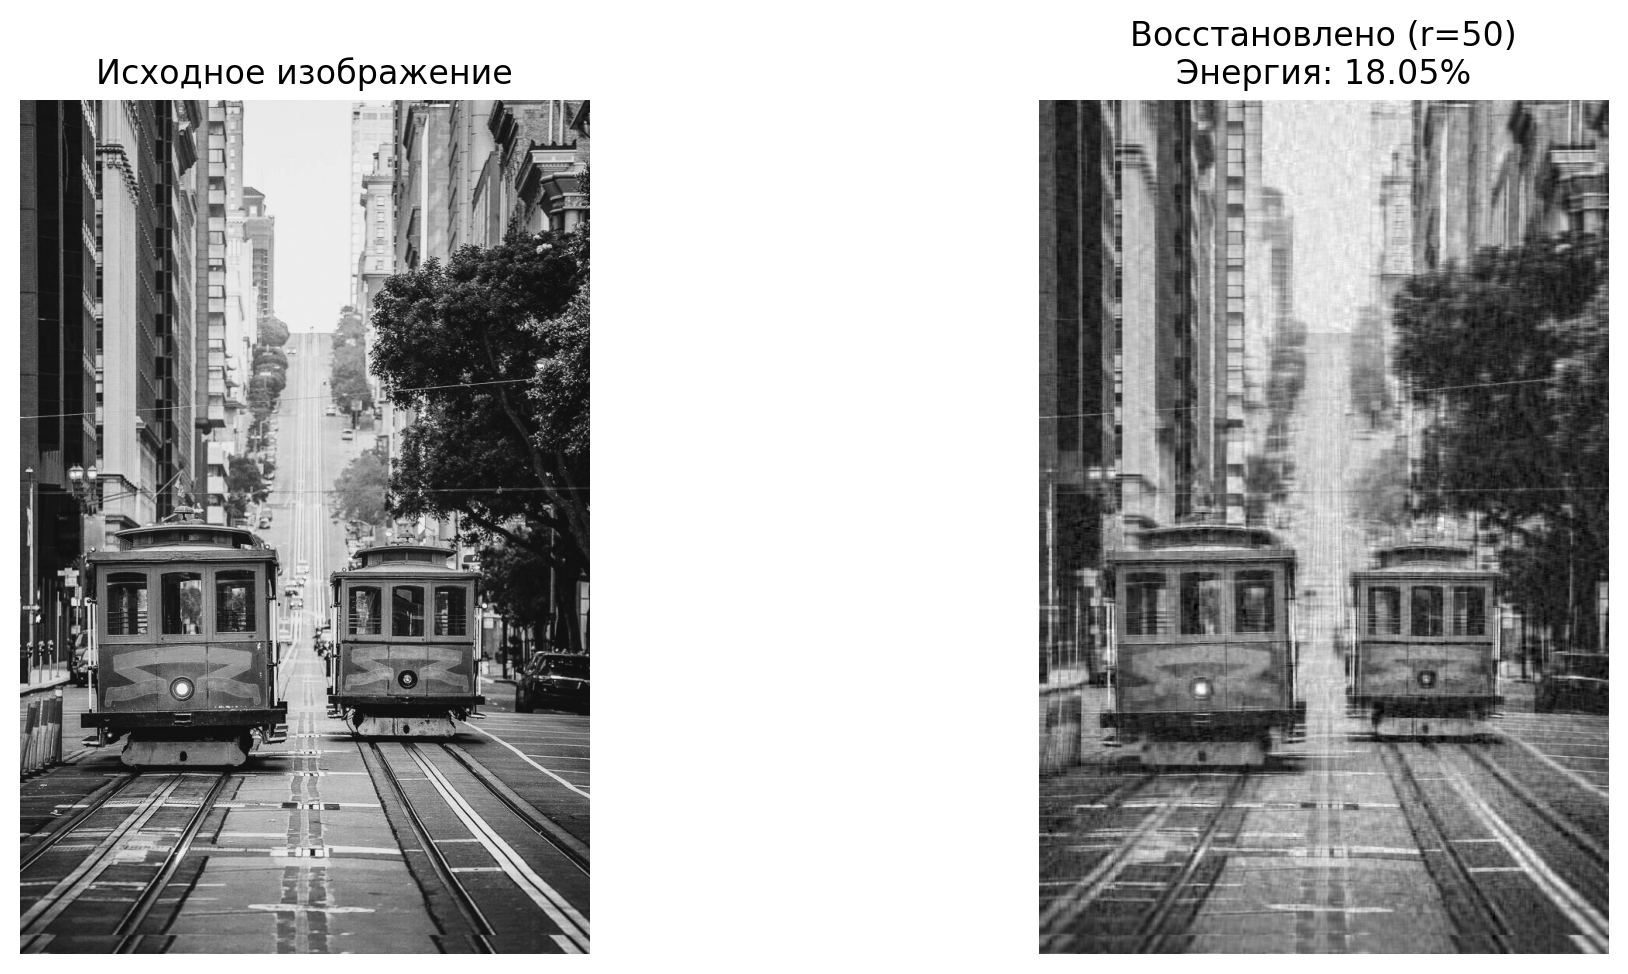

Коэффициент сжатия: 8.83x
Экономия памяти: 88.7%


In [ ]:
# Интерактивное исследование
def show_compression(r):
    """Функция для показа изображения с заданным количеством компонент"""
    reconstructed = U[:, :r] @ np.diag(S[:r]) @ VT[:r, :]
    reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)
    
    energy = cumulative_energy[r-1] * 100
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_array, cmap='gray')
    plt.title('Исходное изображение')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title(f'Восстановлено (r={r})\nЭнергия: {energy:.2f}%')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    original_size = m * n
    compressed_size = m * r + r + r * n
    compression_ratio = original_size / compressed_size
    
    print(f"Коэффициент сжатия: {compression_ratio:.2f}x")
    print(f"Экономия памяти: {(1 - compressed_size/original_size)*100:.1f}%")

# Пример использования
show_compression(50)